In [75]:
from itertools import chain

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

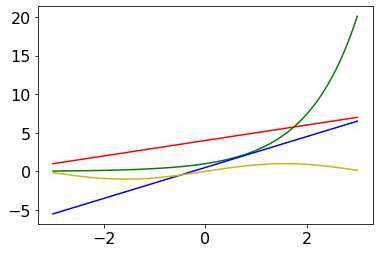

In [76]:
from pytesseract import Output
plt.rcParams.update({'font.size': 16,
                     'savefig.dpi': 300})
# Create an image plot

x = np.linspace(-3,3,100)
plt.plot(x,np.exp(x), 'g')
plt.plot(x, 2 * x + 0.5, 'b')
plt.plot(x, x + 4, 'r')
plt.plot(x, np.sin(x), 'y')

# plt.xticks(np.arange(-3,3.5,1.5))
# plt.yticks(np.arange(-5,7.6,2.5))
plt.savefig("plots/example.png")

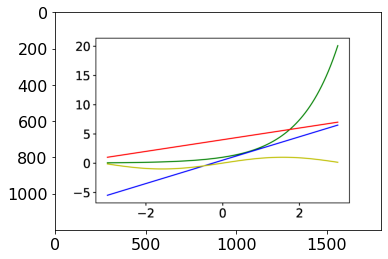

In [77]:
use_image = "plots/example.png"

# Load image into numpy array and display it
base_img = cv2.imread(use_image)

def show_image(img, axis=None, *args, **kwargs):
    # Helper function to disply the image in the correct colors
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if axis is None:
        plt.figure()
        plt.imshow(rgb, *args, **kwargs)
    else:
        axis.imshow(rgb, *args, **kwargs)

show_image(base_img)

In [78]:
class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    @property
    def area(self):
        return self.w * self.h

    def intersect(self, other):
        no_x = not (self.x + self.w < other.x or self.x > other.x + other.w)
        no_y = not (self.y + self.h < other.y or self.y > other.y + other.h)
        return no_x and no_y

    def __str__(self):
        return f"({self.x}, {self.y}, {self.w}, {self.h})"

    def __repr__(self):
        return str(self)

In [79]:
def find_contours(bgr_img):
    """
    Find all contours with corresponding bounding boxes. Therefore we need a binary image for better edge detection
    :param bgr_img: base image in BGR color mode
    :return: list[Rect] of all found rectangles
    """
    img_gray = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [Rect(*cv2.boundingRect(c)) for c in contours]
    return rects

def filter_by_area(rects, std_factor=2):
    """
    Remove all rectanngles from list which area is is greater than _std_factor_ times the standard-dev from the median
    :param rects: list[Rect]
    :param std_factor: float
    :return: list[Rect]
    """
    areas = np.array([r.area for r in rects])
    median = np.mean(areas)
    std = np.std(areas)

    # only keep rectangles with an area of less than std_factor std
    rects = filter(lambda r: abs(r.area - median) <= std_factor * std, rects)
    return  list(rects)

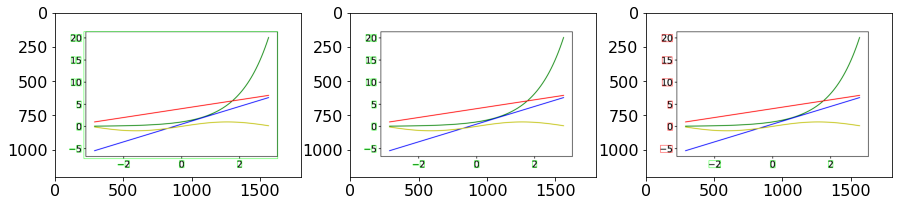

In [89]:
def group_rects_per_axis(rects):
    """
    Gets a list of Rect objects and separates the rectangle into x and y axis.
    This is done by leveraging the fact that x-labels (approx.) all have the same floor point (written on same line)
    :param rects: iterable of Rect objects
    :return: tuple of numpy arrays (x rects,y rects)
    """
    # Get the font size in px to include the "-" of negative values
    font_height = max(r.h for r in rects)
    max_dev = font_height / 2.

    bottom_alignment = np.array([x.y + x.h for x in rects])
    x_boxes_mask = np.abs(bottom_alignment - max(bottom_alignment)) <= max_dev
    x_boxes_indices = np.nonzero(x_boxes_mask)
    y_boxes_indices = np.nonzero(~x_boxes_mask)

    rects = np.array(rects)
    return rects[x_boxes_indices], rects[y_boxes_indices]

def merge_rects(x_arr, y_arr):
    """
    Merge all rectangles which belong together ([1][.][5] -> [1.5]) for x and y axis respectively.
    :param x_arr: iterable of Rect objects
    :param y_arr: iterable of Rect objects
    :return: tuple of list[Rect] objects: outer-x-label-rects, outer-y-label-rects
    """
    def get_min_rects(groups):
        all_rects = []
        for g in groups:
            rects = []
            for r in g:
                rects.append((r.x,r.y))
                rects.append((r.x+r.w,r.y+r.h))
            all_rects.append(Rect(*cv2.boundingRect(np.asarray(rects))))
        return all_rects

    def x_condition(current_elem, last_elem, max_deviation):
        return abs(current_elem.x - (last_elem.x + last_elem.w)) <= max_deviation

    def y_condition(current_elem, last_elem, max_deviation):
        return abs(current_elem.y + current_elem.h - (last_elem.y + last_elem.h)) <= max_deviation

    def merge(arr, condition_fn, sorting_fn, max_dev):
        all_groups = []
        curr_group = []
        for r in sorted(arr, key=sorting_fn):
            if not curr_group:
                curr_group.append(r)
            else:
                last_elem = curr_group[-1]
                if condition_fn(r, last_elem, max_dev):
                    curr_group.append(r)
                else:
                    all_groups.append(curr_group)
                    curr_group = [r]
        all_groups.append(curr_group)
        return get_min_rects(all_groups)

    x = merge(x_arr, x_condition, lambda r: r.x, max(r.w for r in x_arr) / 2.)
    y = merge(y_arr, y_condition, lambda r: (r.y + r.h, r.x), max(r.h for r in y_arr) / 2.)
    return x, y

# bounding rectangles for all contours in the base image
rectangles = find_contours(base_img)
filtered = filter_by_area(rectangles)

# separate into x and y axis labels and then merge close ones to one number
xs, ys = group_rects_per_axis(filtered)
xs, ys = merge_rects(xs, ys)

fig, axes = plt.subplots(1,3, figsize=(15,15))
for ax, r in zip(axes, [rectangles, filtered, (xs, ys)]):
    # Show all contours found
    img2 = base_img.copy()
    if isinstance(r, tuple):
        for c in r[1]:
            img2 = cv2.rectangle(img2, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 0, 255), 2)
        r = r[0]
    for c in r:
        img2 = cv2.rectangle(img2, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
    show_image(img2, ax)


['-1', '-1', '-1', '-1', 0] ['', '', '', '', '-2']
['-1'] ['']
['-1'] ['']
['-1', '-1', '-1', '-1', 96] ['', '', '', '', '20']
['-1', '-1', '-1', '-1', 96] ['', '', '', '', '15']
['-1', '-1', '-1', '-1', 96] ['', '', '', '', '10']
['-1'] ['']
['-1'] ['']
['-1', '-1', '-1', '-1', 0] ['', '', '', '', '-5']
-2.0
20.0
15.0
10.0
-5.0


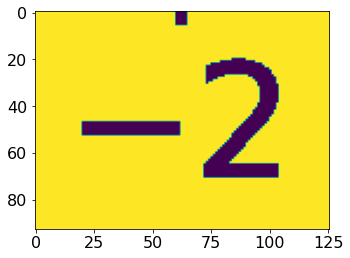

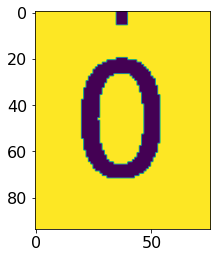

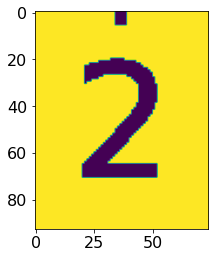

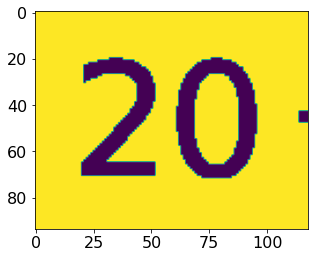

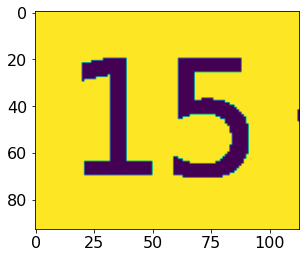

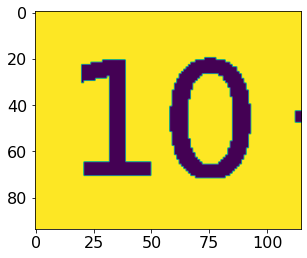

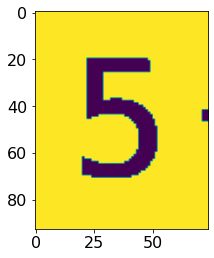

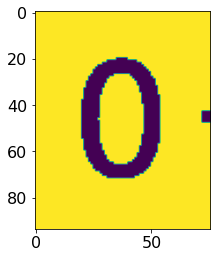

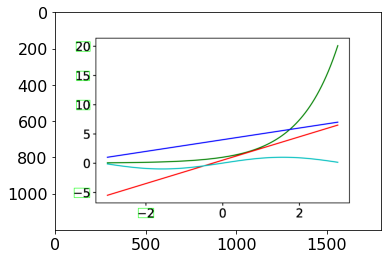

In [93]:
def add_padding_to_box(r, img_shape, border_size=20):
    x = max(0, r.x - border_size)
    y = max(0, r.y - border_size)
    w = min(r.w + 2 * border_size, img_shape[0])
    h = min(r.h + 2 * border_size, img_shape[1])
    return Rect(x,y,w,h)

def boxes_to_label_value(box_list, bin_image):
    """
    OCR Lookup for each value within the bounding box rectangle
    :param box_list:
    :param bin_image:
    :return:
    """
    letter_boxes = []
    for rect in box_list:
        # extra borders to make the contours inside of the rectangle
        padded = add_padding_to_box(rect, base_img.shape)
        roi = bin_image[padded.y:padded.y + padded.h + 1, padded.x:padded.x + padded.w + 1]
        plt.figure()
        plt.imshow(roi)
        
        # TODO: try using an empty image, put in the roi and then apply tesseract. sending once might be cheaper
        ocr_data = pytesseract.image_to_data(roi, output_type=Output.DICT, config=f'--psm 11 -c tessedit_char_whitelist=0123456789.-')
        print(ocr_data["conf"], ocr_data["text"])
        n_boxes = len(ocr_data['text'])
        for i in range(n_boxes):
            # -1 is the empty confidence
            if int(ocr_data['conf'][i]) > -1:
                letter_boxes.append((float(ocr_data["text"][i]), rect))
    return letter_boxes


binary_image = cv2.cvtColor(base_img.copy(), cv2.COLOR_BGR2GRAY)
binary_image = cv2.threshold(binary_image, 0, 255, cv2.THRESH_OTSU)[1]
x_labels = boxes_to_label_value(xs, binary_image)
y_labels = boxes_to_label_value(ys, binary_image)

ocr_img = base_img.copy()
for c, box in chain(x_labels, y_labels):
    ocr_img = cv2.rectangle(ocr_img, (box.x, box.y), (box.x + box.w, box.y + box.h), (0,255,0), 2)
    print(c)
plt.imshow(ocr_img)


In [82]:
class PixelToLabelLookup:
    def __init__(self, x_values, y_values):
        """
        Class to convert found pixels (data values) to the corresponding value as indicated by the axis labels
        """
        self.x = [(r.x + r.w / 2, val) for val, r in x_values]
        self.y = [(r.y + r.h / 2, val) for val, r in y_values]

        print(f"X-Labels: {self.x}")
        print(f"Y-Labels: {self.y}")
        self.x_func, self.y_func = self.linear_regression(self.x), self.linear_regression(self.y)

    @staticmethod
    def linear_regression( mean_points):
        points = np.array(mean_points).T
        assert len(points.shape) == 2

        x, y = points[0], points[1]

        s_xy = np.sum((x - x.mean()) * (y - y.mean()))
        s_xx = np.sum((x - x.mean()) ** 2)

        b = float(s_xy) / s_xx
        intercept = y.mean() - b * x.mean()

        def reg_fn(px):
            return np.round(intercept + b * px, 2)

        return reg_fn

    @property
    def xticks(self):
        return np.array([t[1] for t in self.x])

    @property
    def yticks(self):
        return np.array([t[1] for t in self.y])

    def lookup(self, px):
        return self.x_func(px[0]), self.y_func(px[1])

    def __call__(self, arr: np.ndarray):
        # lookup for a numpy array along the last dimension.
        values = np.apply_along_axis(self.lookup, -1, arr)
        return values

label_lookup = PixelToLabelLookup(x_labels, y_labels)

X-Labels: [(500.5, -2.0)]
Y-Labels: [(189.5, 20.0), (351.0, 15.0), (511.5, 10.0), (995.0, -5.0)]


/home/alex/workspace/reverse-plot/venv/lib64/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


found 4 colors/graphs


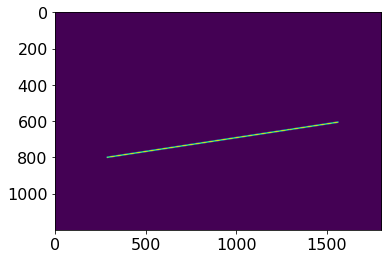

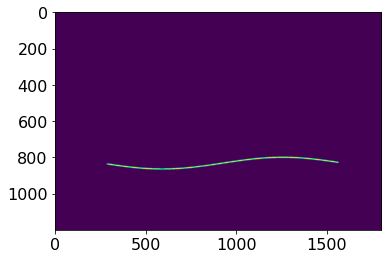

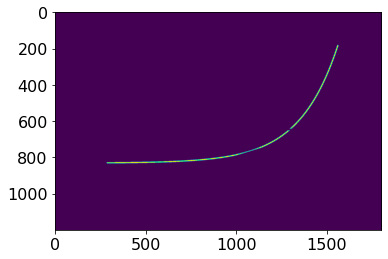

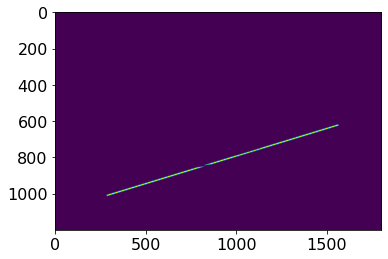

In [83]:
def separate_by_color(img_):
    """
    If we have multiple graphs in a plot, we separate them by color.
    Change into the HSV color space because it better represents the perceived color.
    As we do not have many different colors we can easily threshold them to separate values, using the first (hue) value only
    TODO: problems: this does not work for black graphs
    :param img_:
    :return:
    """
    hsv_img = cv2.cvtColor(img_, cv2.COLOR_BGR2HSV)

    hue_values = np.transpose(hsv_img, (2,0,1))[0].flatten()

    # Get the most frequent hue values, i.e. present colors without noise
    unq, counts = np.unique(hue_values, return_counts=True)
    unique_threshold = 20
    colors = unq[counts > unique_threshold]

    c_masks = {}
    for c in colors:
        # define a range to make red possible as it is [0,255,255]
        lower = np.array([c,50,50])
        upper = np.array([c,255,255])

        mask = cv2.inRange(hsv_img, lower, upper)
        c_masks[c] = mask
        plt.subplots()
        plt.imshow(mask)
    return c_masks

color_masks = separate_by_color(base_img)
print(f"found {len(color_masks)} colors/graphs")

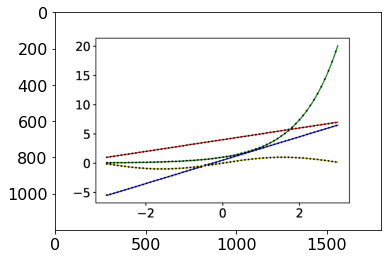

In [84]:
from collections import defaultdict

def get_pixels_for_one_graph(graph_mask, x_resolution=10):
    """

    :param graph_mask: np.ndarray of shape (height, width)
    :param x_resolution: the space between 2 adjacent points
    :return:
    """
    # find non-zero indices
    data = np.argwhere(graph_mask.T > 0)
    data_points_agg = defaultdict(list)
    np.apply_along_axis(lambda row: data_points_agg[row[0]].append(row[1]), -1, data)

    # use the median value for each x value ( as the stroke of a lineplot might be thicker)
    points = np.array([[x, np.median(y)] for x,y in data_points_agg.items()], dtype=np.int)

    # down_scale the points to the given resolution
    down_scale = points[np.arange(0, len(points), x_resolution)]

    return down_scale

def pixel_to_real_ticks(mask_dict):
    pixel, real = {}, {}
    # for each color plot individually
    for color, mask in mask_dict.items():
        points = get_pixels_for_one_graph(mask, x_resolution=20)
        real_values = label_lookup(points)
        pixel[color] = points
        real[color] = real_values
    return pixel, real

pixel_data, real_data = pixel_to_real_ticks(color_masks)

# Draw a circle for each selected data point
cat_img = base_img.copy()
for dp in pixel_data.values():
    for d in dp:
        cv2.circle(cat_img, tuple(d), radius=5, color=(0,0,0), thickness=cv2.FILLED)
show_image(cat_img)

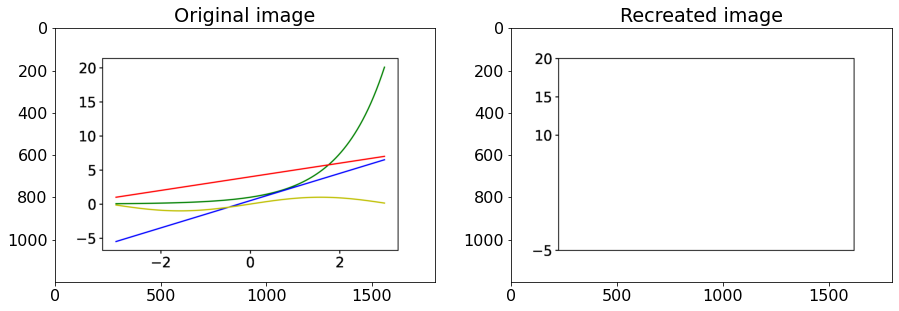

In [85]:
# Pixel data to actual label values
fig = plt.figure()
for c, d in real_data.items():
    color_hue = np.array([[[c, 255,255]]], dtype=np.uint8)
    color_rgb = cv2.cvtColor(color_hue, cv2.COLOR_HSV2RGB).flatten()
    x,y = d.T
    plt.plot(x,y, color=tuple(color_rgb / 255.))

# set the original ticks
plt.xticks(label_lookup.xticks)
plt.yticks(label_lookup.yticks)

res = "plots/result.png"
plt.savefig(res)
# closing prevents it from being shown in Ipython
plt.close(fig)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.set_title("Original image")
ax2.set_title("Recreated image")

show_image(base_img, ax1)
show_image(cv2.imread(res), ax2)
